In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from NeuralNetwork import NeuralNetwork
from Layers import Dense, Conv, Reshape, sigmoid
from tests import *
import matplotlib.pyplot as plt

conv = Conv((2,2),1,0,(2,2),sigmoid,inputShape=(5,5,1))
conv.allocateMemory(1)
ym1 = Tensor(np.random.randn(conv.batchSize,*conv.inputShape))
sigmaOut = Tensor((conv.batchSize,*conv.outputShape))

out1_ = 1
out2_ = 1


outInd1_ = np.zeros(conv.inputShape)
outInd2_ = np.zeros(conv.inputShape)
inInd1_ = np.zeros(conv.outputShape)
inInd2_ = np.zeros(conv.outputShape)
def forwardPropagate(globalIndex,ym1,outSize1,outSize2,filters,stride1,stride2,kernel1,kernel2,inSize1,inSize2,inSize3,padding,v,w,b):
    batch = globalIndex[0]
    filter = globalIndex[1]
    out1 = globalIndex[2]%outSize1
    out2 = globalIndex[2]//outSize1
    
    in1 = out1*stride1-padding
    in2 = out2*stride2-padding
    K1_LIMIT_INF = max(0,-in1)
    K2_LIMIT_INF = max(0,-in2)
    K1_LIMIT_SUP = min(kernel1,inSize1-in1)
    K2_LIMIT_SUP = min(kernel2,inSize2-in2)
    v[batch,out1,out2,filter] = b[filter,]
    for k1 in range(K1_LIMIT_INF, K1_LIMIT_SUP):
        for k2 in range(K2_LIMIT_INF, K2_LIMIT_SUP):
            for dim in range(inSize3):
                in1 = out1*stride1-padding+k1
                in2 = out2*stride2-padding+k2

                outInd1_[in1,in2] = out1+1
                outInd2_[in1,in2] = out2+1
                inInd1_[out1,out2] = in1+1
                inInd2_[out1,out2] = in2+1

                v[batch,out1,out2,filter] += \
                ym1[batch,in1,in2,dim] * \
                w[filter, k1, k2,dim]

outInd1 = np.zeros(conv.inputShape)
outInd2 = np.zeros(conv.inputShape)
inInd1 = np.zeros(conv.outputShape)
inInd2 = np.zeros(conv.outputShape)

def computeLocalGradient(globalIndex,sigmaOut,outSize1,outSize2,filters,inSize1,inSize2,inSize3,kernel1,kernel2,stride1,stride2,padding,sigmaIn,dphi,w):
    batch = globalIndex[0]
    in1 = globalIndex[1]//inSize2
    in2 = globalIndex[1]%inSize2
    in3 = globalIndex[2]
    K1_LIMIT_INF = max(0,in1-outSize1*stride1+padding+1)+in1%stride1
    K2_LIMIT_INF = max(0,in2-outSize2*stride2+padding+1)+in2%stride2
    K1_LIMIT_SUP = min(kernel1,in1+padding+1)
    K2_LIMIT_SUP = min(kernel2,in2+padding+1)
    sigmaIn[batch,in1,in2,in3] = 0
    for k1 in range(K1_LIMIT_INF,K1_LIMIT_SUP,stride1):
        for k2 in range(K2_LIMIT_INF,K2_LIMIT_SUP,stride2):
            for out3 in range(filters):
                out1 = (in1-k1+padding)//stride1
                out2 = (in2-k2+padding)//stride2
                if out1 == out1_ and out2 == out2_:
                    if in1 == 4 and in2 == 4:
                        print(in1,in2,out1,out2)
                        print(K1_LIMIT_INF,K1_LIMIT_SUP)
                    outInd1[in1,in2] = out1+1
                    outInd2[in1,in2] = out2+1
                    inInd1[out1,out2] = in1+1
                    inInd2[out1,out2] = in2+1
                sigmaIn[batch,in1,in2,in3] += w[out3,k1,k2,in3] \
                    *sigmaOut[batch,out1,out2,out3] \
                        *dphi[batch,out1,out2,out3]

output = runCPUKernel(forwardPropagate,conv.GPUForwardPropagate,(ym1,),ind=[0,0,out1_*conv.outputShape[1]+out2_])
ym1, v, w, b = output[0],output[-3],output[-2],output[-1] 
#print(v.accessed.squeeze())
#print(ym1.accessed.squeeze())

output = runCPUKernel(computeLocalGradient,conv.computeLocalGradient,(sigmaOut,))
#output[0].array[np.logical_not(output[0].accessed)] = 0
#print(output[0].array.squeeze())



NameError: name 'runCPUKernel' is not defined

In [ ]:
print(outInd1_.squeeze())
print(outInd1.squeeze())

In [ ]:
print(outInd2_.squeeze())
print(outInd2.squeeze())

In [ ]:
print(inInd1_.squeeze())
print(inInd1.squeeze())

In [ ]:
print(inInd2_.squeeze())
print(inInd2.squeeze())

In [5]:
conv1.v.shape

(10, 5, 5, 3)

In [1]:
from NeuralNetwork import NeuralNetwork
from Layers import Dense, Conv, Reshape, sigmoid
from Tests import CPUvsGPU

conv1 = Conv((5,5),sigmoid, filters = 3, padding = 2, strides=(2,2),inputShape=(10,10,1))
conv1.allocateMemory(10)

CPUvsGPU.testConv(conv1)

/opt/anaconda3/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


PASSED forwardPropagate
PASSED sigmoidTest
PASSED computedb
PASSED computeGradients
PASSED computeLocalGradient
PASSED learningRule


In [1]:
from NeuralNetwork import NeuralNetwork
from Layers import *
from Tests.AproximateGradientTest import gradientTest
model = NeuralNetwork([Conv((5,5),sigmoid, filters = 3, padding = 2, strides=(2,2),inputShape=(10,10,1)),
                        #Conv((3,3),6,0,(1,1),sigmoid),
                        Conv((2,2),sigmoid,filters = 6), # GRADIENT LOCALS NOT WORKING PROPPERLY
                        Reshape(-1), 
                        Dense(3,sigmoid),
                        Reshape(-1), 
                        Dense(3,sigmoid)])
dw,db,plotter = gradientTest(model)

/opt/anaconda3/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


PASSED Layer 0 dw r2= 1.0, m= 0.5, b= 0.0,
PASSED Layer 0 db r2= 1.0, m= 0.5, b= -0.0,
PASSED Layer 1 dw r2= 1.0, m= 0.51, b= 0.0,
PASSED Layer 1 db r2= 1.0, m= 0.51, b= 0.0,
PASSED Layer 3 dw r2= 1.0, m= 0.49, b= -0.0,
PASSED Layer 3 db r2= 1.0, m= 0.49, b= 0.0,
PASSED Layer 5 dw r2= 1.0, m= 0.5, b= 0.0,
PASSED Layer 5 db r2= 1.0, m= 0.5, b= 0.0,


In [4]:
from NeuralNetwork import NeuralNetwork
from Layers import Dense, Conv, Reshape, sigmoid
from tests import *
import matplotlib.pyplot as plt
from tests import gradientTest
model = NeuralNetwork([Conv((5,5),6,2,(2,2),sigmoid,inputShape=(10,10,1)),
                        #Conv((3,3),6,0,(1,1),sigmoid),
                        Conv((2,2),6,0,(2,2),sigmoid),
                        Reshape(-1), 
                        Dense(3,sigmoid)])
model.allocateMemory(1)

In [1]:
from NeuralNetwork import NeuralNetwork
from Layers import Dense, Conv, Reshape, sigmoid
from tests import *
import matplotlib.pyplot as plt
from tests import gradientTest
model = NeuralNetwork([Conv((5,5),6,2,(2,2),sigmoid,inputShape=(10,10,1)),
                        #Conv((3,3),6,0,(1,1),sigmoid),
                        Conv((2,2),6,0,(1,1),sigmoid),
                        Reshape(-1), 
                        Dense(3,sigmoid)])

dw,db,plotter = gradientTest(model)
model

FAILED Layer 0 dw r2= 0.0, m= 0.0, b= 0.0,
FAILED Layer 0 db r2= 0.0, m= 0.0, b= 0.0,
FAILED Layer 1 dw r2= -0.0, m= 0.0, b= 0.0,
FAILED Layer 1 db r2= -0.0, m= 0.0, b= 0.0,
FAILED Layer 3 dw r2= 0.0, m= 0.0, b= 0.0,
PASSED Layer 3 db r2= 1.0, m= 9.12, b= -0.0,


		 MODEL SUMMARY: 
Input: 		 (10, 10, 1)
Conv Layer: 		(5, 5, 6)
Conv Layer: 		(4, 4, 6)
Reshape Layer: 		(96,)
Dense Layer: 		(3,)

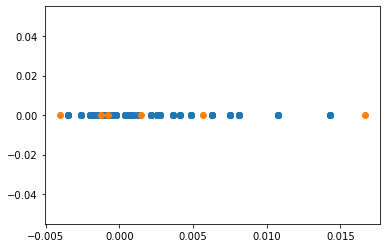

In [8]:
plotter(-3)

In [3]:
from tests import *
from LayerTests.Convolutional import *
batchSize = 10
conv = Conv((5,5),3,1,(2,2),sigmoid, inputShape=(10,10,1))
conv.allocateMemory(batchSize)
ym1 = Tensor(np.random.randn(batchSize,*conv.inputShape))
sigmaOut = Tensor(np.random.randn(batchSize,*conv.outputShape))



PASSED forwardPropagate
PASSED sigmoidTest
PASSED computedb
PASSED computeGradients
PASSED computeLocalGradient
FAILED learningRule
Param Index 6 with name "w" was off by 4.580564975738525
Param Index 7 with name "b" was off by 0.7990346550941467



In [9]:
sigmaOut.shape

(10, 8, 8, 2)

In [8]:
sigmaOut.get()[:,:,1]

array([[[0., 0.],
        [1., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.],
        [6., 6.],
        [7., 7.]],

       [[7., 7.],
        [8., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.],
        [6., 6.],
        [7., 7.]],

       [[7., 7.],
        [8., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.],
        [6., 6.],
        [7., 7.]],

       [[7., 7.],
        [8., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.],
        [6., 6.],
        [7., 7.]],

       [[7., 7.],
        [8., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.],
        [6., 6.],
        [7., 7.]],

       [[7., 7.],
        [8., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.],
        [6., 6.],
        [7., 7.]],

       [[7., 7.],
        [8., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.],
        [6., 6.]

In [2]:
print(out2['not accesed ym1'][0,:,:,0])

NameError: name 'out2' is not defined